In [1]:
import mne                                                              # Librería de python para explorar, visualizar,
mne.set_log_level('WARNING')                                            # y analizar datos neurofisiológicos humanos.
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb                                                    
color = ['green', 'blue','red','cyan', 'magenta', 'yellow','k','w']     # Paleta de colores para diferenciar las ondas

import a_funciones as a_fun                                             # Funciones Alex

xlabel = 'Muestra'                                                      # Abscisas
ylabel = 'Amplitud (uV)'                                                # Ordenadas

In [2]:
#import mne
#mne.set_log_level('WARNING')
#import scipy.io
#import numpy as np

# First load the template.  This is the signal that will be used to DRUG the basal EEG stream.
mat = scipy.io.loadmat('./dataset/ERPTemplate.mat')

routput = mat['routput']

# In this ERPTemplate, there are two different template signals that are good.
erptemplate1 = routput[0][7][0][1][0][0][0][7] 
erptemplate2 = routput[0][7][0][1][0][0][0][0] 

# The original ERPTemplate dataset has a sampling frequency of 256 so I need to perform a small downsampling to 250 Hz
erptemplate1 = np.delete( erptemplate1, range(0,256,43),0)
erptemplate2 = np.delete( erptemplate2, range(0,256,43),0)

# Use this for testing  (get a ZERO signal)
#erptemplate1 = np.zeros((250,8))

# Randomize amplitude and jitter.
# Find the right locations where this should be inserted in the stream.
# Insert the signal mantaining the continiuity of the EEG.
def DrugSignal(signal, t_flash):
    '''
    Randomize amplitude and jitter
    Find the right locations where this should be inserted in the stream
    Insert the template mantaining the continuity and physiological meaning of the EEG
    '''
    for i in range(0,4200):
        if (t_flash[i,3]==2):
            signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (erptemplate1*3)

    return signal

# Now load the basal EEG stream
mat = scipy.io.loadmat('./dataset/p300-subject-25.mat')
#mat = scipy.io.loadmat('./dataset/p300-subject-26.mat')
#mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-21.mat')
#mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-06.mat')

# In[1]:

# coding: latin-1
# Data point zero for the eight channels.  Should be in V.
signal = mat['data'][0][0][0] 
#* pow(10,6)

# Trials
t_trials = mat['data'][0][0][3]

# Flash matrix
t_flash = mat['data'][0][0][4]

signal = DrugSignal(signal, t_flash)

t_stim = mat['data'][0][0][2]
t_type = mat['data'][0][0][1]

### Análisis de DrugSignal.py, parte II  
  
En *a_analisis_funcion_DrugSignal.ipynb* se llega a drogar la señal con variaciones en la amplitud y fase.  
A continuación la preparación de los datos para ser visualizados con la librería de python mne.  
  
[*Creating data objects from arrays. mne library*](https://mne.tools/stable/creating_from_arrays.html)  
  
- Una instancia básica de información llamada *info_events*:  
Esta contiene el nombre de los canales, el ratio de muestreo y el canal de datos.  
Para éste caso no se usará canal de datos, por eso se carga *ch_types_events* con ['misc'].  
  
- Un objeto "en crudo" a partir de un array de numpy llamado *eeg*.  

- Un tercer objeto *event_times* que trae la info completa y además agrega el 't_type',
profundizado en [*a_analisis_p300subject25_stim&type.ipynb*](a_analisis_p300subject25_stim&type.ipynb).

C:\Users\alexc\AppData\Local\Temp/ipykernel_83972/1281448246.py:15: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig=eeg.plot_psd()


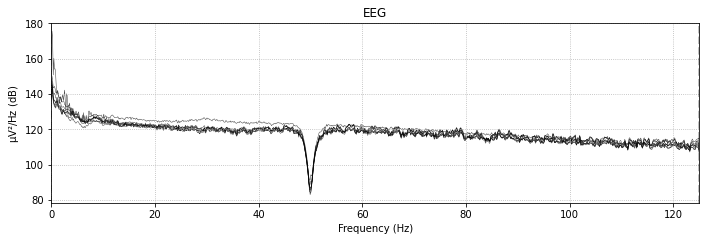

C:\Users\alexc\AppData\Local\Temp/ipykernel_83972/1281448246.py:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig=eeg.plot_psd()


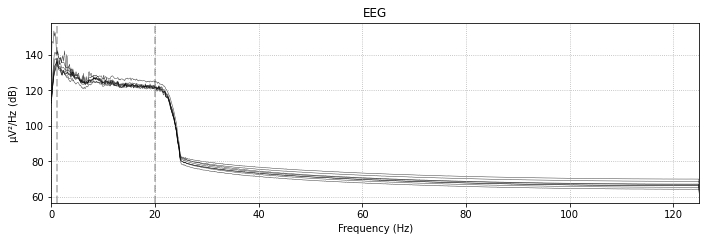

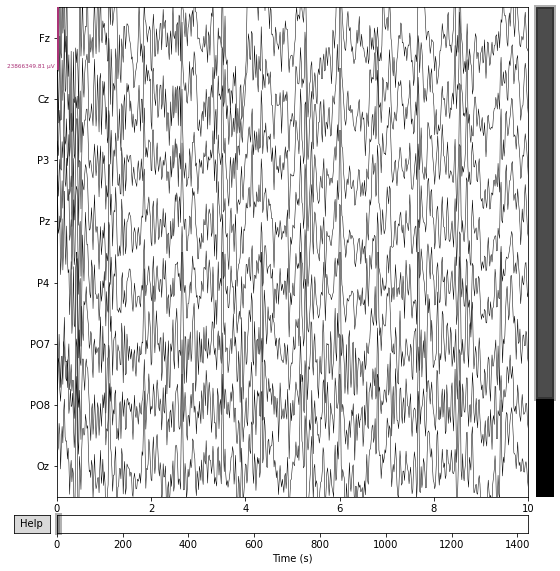

In [3]:
ch_names=['Fz','Cz','P3','Pz','P4','PO7','PO8', 'Oz']                   # Los nombres de los canales
ch_types= ['eeg'] * signal.shape[1]                                     # Un vector de tamaño 8 con el'eeg' repetido
ch_names_events = ch_names + ['t_stim']+ ['t_type']                     # Le agrega  't_stim' y't_type' 
ch_types_events = ch_types + ['misc'] + ['misc']                        # Le agrega dos 'misc': 
                                                                        # Channel types, default is 'misc' which is not a data channel. 
                                                                        # Currently supported fields are ‘ecg’, ‘bio’, ‘stim’, ‘eog’, ‘misc’, 
                                                                        # ‘seeg’, ‘dbs’, ‘ecog’, ‘mag’, ‘eeg’, ‘ref_meg’, ‘grad’, ‘emg’, ‘hbr’ or ‘hbo’. 
                                                                        # If str, then all channels are assumed to be of the same type.
#info = mne.create_info(ch_names, 250, ch_types=ch_types)
#eeg_mne = mne.io.array.RawArray(signal.T, info)

signal_events = np.concatenate([signal, t_stim, t_type],1)              # Se agrega a la señal drogada 't_stim' y 't_type'
df_signal_events = a_fun.to_df(signal_events)
info_events = mne.create_info(ch_names_events,250, ch_types_events)     # Acá crea los eventos. 
eeg = mne.io.RawArray(signal_events.T, info_events)                     # El objeto en crudo.

# Do some basic signal processing (1-20 band pass filter)
fig=eeg.plot_psd()
eeg.filter(1,20)
fig=eeg.plot_psd()
event_times = mne.find_events(eeg, stim_channel='t_type')    
eeg.plot(scalings='auto',n_channels=8,events=event_times,block=True)   # scalings=10e-05
#======================================================================================================================================
# In[1]
if (np.unique(t_flash[:,0]).shape[0] != 4200):                          # evalúa si el "sample point id" de t_flash tiene el tamaño correcto.
    u,c = np.unique( t_flash[:,0], return_counts=True)                  # u->Los elementos únicos. c->la cantidad de veces que se repiten.
    dup = u[c>1]                                                        # dup->Los que estén repetidos mas de una vez.    
    
    for i in range(dup.shape[0]):
        idx = np.where( t_flash[:,0] == dup[i] )[0][0]
        t_flash[idx,0]  -= 1
        t_flash[idx,1]  = 1
        t_type[t_flash[idx,0]] = t_flash[idx,3]
        t_stim[t_flash[idx,0]] = t_flash[idx,2]

# In[1]:
np.unique(t_flash[:,0]).shape
assert  np.unique(t_flash[:,0]).shape[0] == 4200, 'Problem with experiment structure.  There aren''t enough events.'


#### FunciONES para obtener las estimulaciones, etiquetas y.
  
### getstims.  
La función usa *info*, que es creada con los nombres de los canales (ch_names), la frecuencia de muestreo (259) y los tipos de canales ch_types.  También toma como entrada *eeg_mne*; es la traspuesta de signal e info.

El resultado *event_times* es llamando a la función *find_events* de mne, que encuentra eventos del archivo "raw".  

[*"Find events"*](https://mne.tools/stable/generated/mne.find_events.html)  



[*"Épocas: INVESTIGAR. NO ENTENDI NADA"*](https://mne.tools/stable/generated/mne.Epochs.html#mne-epochs)

### getlabels.



- Una instancia básica de información llamada *info_events*:  
Esta contiene el nombre de los canales, el ratio de muestreo y el canal de datos.  
Para éste caso no se usará canal de datos, por eso se carga *ch_types_events* con ['misc'].  
  
- Un objeto "en crudo" a partir de un array de numpy llamado *eeg*.  

- Un tercer objeto *event_times* que trae la info completa y además agrega el 't_type',
profundizado en [*a_analisis_p300subject25_stim&type.ipynb*](a_analisis_p300subject25_stim&type.ipynb).

In [ ]:
def getstims(eeg_mne, eeg_events):
    '''
    Get the stimulations.  These are the FLASHINGS of rows and columns.
    '''
    tmin = 0
    tmax = 0.8
    reject = None
    event_times = mne.find_events(eeg_events, stim_channel='t_stim',shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
    event_id = {'Row1':1,'Row2':2,'Row3':3,'Row4':4,'Row5':5,'Row6':6,'Col1':7,'Col2':8,'Col3':9,'Col4':10,'Col5':11,'Col6':12}


    epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                    baseline=None, reject=reject, preload=True,
                    verbose=True, reject_by_annotation=None)


    stims = event_times[:,-1]

    return [epochs,stims]

stimepochs, stims = getstims(eeg, eeg)

def getlabels(eeg_mne, eeg_events, event_id):
    '''
    Get the hit/no hits labels.  These are the FLASHINGS of rows and columns but selected if they are the ones that will
    trigger the P300 response or not.
    '''
    #event_id = { 'first':1, 'second':2 }
    #baseline = (0.0, 0.2)
    #reject = {'eeg': 70 * pow(10,6)}
    tmin = 0
    tmax = 0.8
    reject = None
    event_times = mne.find_events(eeg_events, stim_channel='t_type', shortest_event=0, verbose=True, min_duration=0.000001, consecutive=True)
    epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                    baseline=None, reject=reject, preload=True,
                    verbose=True, reject_by_annotation=None)
    labels = epochs.events[:, -1]
    return [epochs, labels]

epochs, labels = getlabels(eeg, eeg, {'first':1})

epocked = epochs.average()
epocked.plot(window_title='NoHit Averaged Signals')


epochs, labels = getlabels(eeg, eeg, {'second':2})

epocked = epochs.average()
epocked.plot(window_title='Hit Averaged Signals')

epochs, labels = getlabels(eeg, eeg, { 'first':1, 'second':2})


# Downsample the original FS=250 Hz signal to >>> 20 Hz
#epochs.resample(20, npad="auto")
#stimepochs.resample(20, npad="auto")
repetitions=120